In [1]:
## Two-Class EEG Classification using LSTM-based RNN
## Here, we develop a baseline model for using an RNN to perform time-series prediction for one of two motor
## imagery (MI) tasks. The data from the file CLA_SubjectJ-170508-3St-LRHand-Inter.mat is processed and we
## only keep the data points that pertain to the left and right hand MI tasks. Each of the MI task data consists
## of 170 time steps, with each time step consisting of 22 inputs. In other words, we pass the current sample for
## of the 22 channels for each time step. At the end of the 170 time step, we send the output of the LSTM layers
## to a Dense layer with two outputs. To ease the classification at the outer layer, we have converted the class
## into a one-hot encoding of zeros and ones, and use the sigmoid unit at the output to match the output range.

## Preliminary results:
## Performance on training set is 100% classification rate after around 30 to 40 epochs.
## Performance on test set is around 60% - 68%.

## Potential problems:
## The total amount of data is relatively low. Can it be possible to combine multiple subject's L/R Hand MI data
## into one unified data set?
## Can also possible increase the size of the data set by doing some data augmentations.
## For example, injecting some noise into the existing EEG data to create more test data?

## Followup/TODO:
## Use pre-implemented common spatial patterns for feature extraction: avialable here: https://github.com/spolsley/common-spatial-patterns
## Try using a relatively simple non-linear energy operator as a pre-emphasis step on the data to see if it helps generalize
## the model.

In [2]:
## This file is used to split data into series of arrays and their corresponding MI task.
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
file = sio.loadmat('../mat_files/CLA-SubjectJ-170508-3St-LRHand-Inter.mat') #replace with .mat file name
header=file['__header__']
version=file['__version__']
glob=file['__globals__']
ans=file['ans']


x=file['x']
o=file['o'][0][0]
data=o['data']
data = np.transpose(data)
data = data[0:21,:]
print(data)
nS=o['nS'][0][0]
#values of structure seem to be 2D numpy arrays, if originally a scalar in Matlab.
#use [0][0] to get scalar.
print("Number of samples: {numSamples}".format(numSamples=nS))
test=o['id'][0] #id value became a 1D array of size 1 for some reason. use [0] to get value
print("Dataset ID: {id}".format(id=test))
chnames=o['chnames'][:,0] #[:,0] converts from 2D array back to 1D array
print("Channel names: {channelNames}".format(channelNames=chnames))
markers = o['marker']
## The markers are all still individual arrays of size 1x1, so we convert them to an array with single values
markersArray = []
for marker in markers:
    markersArray.append(marker[0])
markersArray = np.asarray(markersArray)
#For this dataset, the markers are 0, 1, or 2.
# 1 - Left Hand MI, 2 - Right Hand MI, 3 - Passive State, 0 - Rest (???)

[[-18.   -3.6  -6.6 ...  -9.   -7.2  -2.4]
 [-19.2  -0.   -8.4 ...  -8.4 -11.4  -9. ]
 [-12.    1.8  -1.2 ...   2.4   3.6   5.4]
 ...
 [ -7.2   7.2   1.8 ...   1.8   4.2   4.2]
 [ -6.    5.4   3.  ...   5.4   4.2   3.6]
 [ -8.4   7.2   3.  ...   4.8   6.6   6. ]]
Number of samples: 621892
Dataset ID: 201705081338.32BEA9DD
Channel names: [array(['Fp1'], dtype='<U3') array(['Fp2'], dtype='<U3')
 array(['F3'], dtype='<U2') array(['F4'], dtype='<U2')
 array(['C3'], dtype='<U2') array(['C4'], dtype='<U2')
 array(['P3'], dtype='<U2') array(['P4'], dtype='<U2')
 array(['O1'], dtype='<U2') array(['O2'], dtype='<U2')
 array(['A1'], dtype='<U2') array(['A2'], dtype='<U2')
 array(['F7'], dtype='<U2') array(['F8'], dtype='<U2')
 array(['T3'], dtype='<U2') array(['T4'], dtype='<U2')
 array(['T5'], dtype='<U2') array(['T6'], dtype='<U2')
 array(['Fz'], dtype='<U2') array(['Cz'], dtype='<U2')
 array(['Pz'], dtype='<U2')]


In [3]:
## CSP File from: https://github.com/spolsley/common-spatial-patterns
# CSP takes any number of arguments, but each argument must be a collection of trials associated with a task
# That is, for N tasks, N arrays are passed to CSP each with dimensionality (# of trials of task N) x (feature vector)
# Trials may be of any dimension, provided that each trial for each task has the same dimensionality,
# otherwise there can be no spatial filtering since the trials cannot be compared
def CSP(*tasks):
	if len(tasks) < 2:
		print("Must have at least 2 tasks for filtering.")
		return (None,) * len(tasks)
	else:
		filters = ()
		# CSP algorithm
		# For each task x, find the mean variances Rx and not_Rx, which will be used to compute spatial filter SFx
		iterator = range(0,len(tasks))
		for x in iterator:
			# Find Rx
			Rx = covarianceMatrix(tasks[x][0])
			for t in range(1,len(tasks[x])):
				Rx += covarianceMatrix(tasks[x][t])
			Rx = Rx / len(tasks[x])

			# Find not_Rx
			count = 0
			not_Rx = Rx * 0
			for not_x in [element for element in iterator if element != x]:
				for t in range(0,len(tasks[not_x])):
					not_Rx += covarianceMatrix(tasks[not_x][t])
					count += 1
			not_Rx = not_Rx / count

			# Find the spatial filter SFx
			SFx = spatialFilter(Rx,not_Rx)
			filters += (SFx,)

			# Special case: only two tasks, no need to compute any more mean variances
			if len(tasks) == 2:
				filters += (spatialFilter(not_Rx,Rx),)
				break
		return filters

# covarianceMatrix takes a matrix A and returns the covariance matrix, scaled by the variance
def covarianceMatrix(A):
	Ca = np.dot(A,np.transpose(A))/np.trace(np.dot(A,np.transpose(A)))
	return Ca

# spatialFilter returns the spatial filter SFa for mean covariance matrices Ra and Rb
def spatialFilter(Ra,Rb):
	R = Ra + Rb
	E,U = la.eig(R)

	# CSP requires the eigenvalues E and eigenvector U be sorted in descending order
	ord = np.argsort(E)
	ord = ord[::-1] # argsort gives ascending order, flip to get descending
	E = E[ord]
	U = U[:,ord]

	# Find the whitening transformation matrix
	P = np.dot(np.sqrt(la.inv(np.diag(E))),np.transpose(U))

	# The mean covariance matrices may now be transformed
	Sa = np.dot(P,np.dot(Ra,np.transpose(P)))
	Sb = np.dot(P,np.dot(Rb,np.transpose(P)))

	# Find and sort the generalized eigenvalues and eigenvector
	E1,U1 = la.eig(Sa,Sb)
	ord1 = np.argsort(E1)
	ord1 = ord1[::-1]
	E1 = E1[ord1]
	U1 = U1[:,ord1]

	# The projection matrix (the spatial filter) may now be obtained
	SFa = np.dot(np.transpose(U1),P)
	return SFa.astype(np.float32)

In [4]:
## Find the starting indeces where the marker changes
changeIdxs = np.where(np.transpose(markersArray)[:-1] != np.transpose(markersArray)[1:])[0]
print("Number of index changes: {idxChanges}".format(idxChanges=changeIdxs.shape[0]))
## Split the data so that it has its matching marker
dataSplit = np.array_split(data, changeIdxs[:-1], axis=1)
splitCount = 0
for splitData in dataSplit:
    splitCount += 1
print("Number of arrays in data split: {num}".format(num=splitCount))
## Retrieve the marker values for each of the change indeces (changeIdxs)
markerTargets = markersArray[changeIdxs];
print("Number of marker targets: {numTargets}".format(numTargets=markerTargets.shape[0]))
markerTargetsOriginal = markerTargets

Number of index changes: 1800
Number of arrays in data split: 1800
Number of marker targets: 1800


In [5]:
## To Apply CSP, we first only get the indeces for MI tasks 1 and 2 (left and right hand, respectively.)
LeftIdxs = np.where(markerTargets == 1)
RightIdxs = np.where(markerTargets == 2)
numLeftIdx = LeftIdxs[0].shape

In [6]:
leftData = [];
for leftIndex in LeftIdxs[0]:
    #print(leftIndex)
    #print("Dimensions of index: {ind}".format(ind=dataSplit[leftIndex].shape))
    if(dataSplit[leftIndex].shape[1] != 170):
        continue
    else:
        leftData.append(np.transpose(dataSplit[leftIndex]))
leftData = np.asarray(leftData)
leftData.shape

(288, 170, 21)

In [7]:
rightData = [];
for rightIndex in RightIdxs[0]:
    #print(leftIndex)
    #print("Dimensions of index: {ind}".format(ind=dataSplit[leftIndex].shape))
    if(dataSplit[rightIndex].shape[1] != 170):
        continue
    else:
        rightData.append(np.transpose(dataSplit[rightIndex]))
rightData = np.asarray(rightData)
rightData.shape

(327, 170, 21)

In [8]:
## Only keep the top 288 samples, so that left and right data are equal
rightDataSub = rightData[1:289]

In [9]:
#Construct the target array and merge the data
leftTargets = np.tile(np.array([1,0]),(288,1))
rightTargets = np.tile(np.array([0,1]), (288,1))
markerTargets = np.vstack((leftTargets, rightTargets))
lrData = np.vstack((leftData, rightDataSub))

#Sanity Check
print("lrData Shape: {arg1}\tmarkerTargets Shape: {arg2}".format(arg1=lrData.shape, arg2=markerTargets.shape))

lrData Shape: (576, 170, 21)	markerTargets Shape: (576, 2)


In [10]:
## Construct LSTM using Tensorflow + Keras
# Import Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import optimizers

In [11]:
## Shuffle the data
lrData, markerTargets = shuffle(lrData, markerTargets, random_state=0)

In [12]:
## Split into train and test sets
lrDataTrain, lrDataTest, markerTargetsTrain, markerTargetsTest = train_test_split(lrData, markerTargets, test_size=0.3, random_state=1)
markerTargetsTrain.shape

(403, 2)

In [13]:
## Reshape the data for time-series processing
## Syntax np.reshape((numExamples, numTimeSteps, numInputs/numFeatures))
lrDataTrainRe = lrDataTrain.reshape((lrDataTrain.shape[0], lrDataTrain.shape[1], lrDataTrain.shape[2]))
lrDataTestRe = lrDataTest.reshape((lrDataTest.shape[0], lrDataTest.shape[1], lrDataTest.shape[2]))

In [14]:
## Construct the model
LSTM_EEG = Sequential()
LSTM_EEG.add(LSTM((100),batch_input_shape=(None,lrDataTrainRe.shape[1], lrDataTrainRe.shape[2]), return_sequences=True))
LSTM_EEG.add(LSTM((50), return_sequences=False))
LSTM_EEG.add(Dense((2),activation='sigmoid'))

In [15]:
LSTM_EEG.summary()
sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
LSTM_EEG.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 170, 100)          48800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 79,102
Trainable params: 79,102
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = LSTM_EEG.fit(lrDataTrain, markerTargetsTrain, epochs=30,verbose=2, batch_size=16)

Epoch 1/30
26/26 - 2s - loss: 0.6648 - accuracy: 0.5980
Epoch 2/30
26/26 - 2s - loss: 0.5965 - accuracy: 0.6700
Epoch 3/30
26/26 - 2s - loss: 0.5378 - accuracy: 0.7221
Epoch 4/30
26/26 - 2s - loss: 0.4529 - accuracy: 0.7891
Epoch 5/30
26/26 - 2s - loss: 0.4530 - accuracy: 0.7841
Epoch 6/30
26/26 - 2s - loss: 0.4635 - accuracy: 0.7965
Epoch 7/30
26/26 - 2s - loss: 0.3715 - accuracy: 0.8263
Epoch 8/30
26/26 - 2s - loss: 0.2825 - accuracy: 0.8759
Epoch 9/30
26/26 - 2s - loss: 0.2819 - accuracy: 0.8908
Epoch 10/30
26/26 - 3s - loss: 0.2023 - accuracy: 0.9181
Epoch 11/30
26/26 - 2s - loss: 0.2856 - accuracy: 0.8710
Epoch 12/30
26/26 - 2s - loss: 0.2943 - accuracy: 0.8710
Epoch 13/30
26/26 - 3s - loss: 0.2400 - accuracy: 0.9231
Epoch 14/30
26/26 - 3s - loss: 0.1708 - accuracy: 0.9529
Epoch 15/30
26/26 - 3s - loss: 0.1199 - accuracy: 0.9653
Epoch 16/30
26/26 - 2s - loss: 0.1084 - accuracy: 0.9702
Epoch 17/30
26/26 - 2s - loss: 0.2389 - accuracy: 0.8908
Epoch 18/30
26/26 - 2s - loss: 0.2385 - 

In [17]:
predictionsTest = LSTM_EEG.predict(lrDataTest)

In [18]:
predictionsTest[predictionsTest>0.5] = 1

In [19]:
predictionsTest[predictionsTest <= 0.5] = 0

In [20]:
comparisonArrayTest = predictionsTest == markerTargetsTest

In [21]:
correctCountTest = 0
for boolValues in comparisonArrayTest:
    if(boolValues[0] & boolValues[1]):
        correctCountTest += 1
falseCountTest = lrDataTest.shape[0] - correctCountTest

predictionsTrain = LSTM_EEG.predict(lrDataTrain)
predictionsTrain[predictionsTrain>0.5] = 1;
predictionsTrain[predictionsTrain<=0.5] = 0;
comparisonArrayTrain = predictionsTrain == markerTargetsTrain;

correctCountTrain = 0
for boolValues in comparisonArrayTrain:
    if(boolValues[0] & boolValues[1]):
        correctCountTrain += 1
falseCountTrain = lrDataTrain.shape[0] - correctCountTrain

In [22]:
print("#################################")
print("#################################")
print("Training Performance:\nCorrect MI Prediction: {}\nIncorrect MI Prediction: {}\nPercent Accuracy: {:.3f}%".format(correctCountTrain, falseCountTrain, (correctCountTrain*100/lrDataTrain.shape[0])))
print("#################################")
print("#################################")
print("Testing Performance:\nCorrect MI Prediction: {}\nIncorrect MI Prediction: {}\nPercent Accuracy: {:.3f}%".format(correctCountTest, falseCountTest, (correctCountTest*100/lrDataTest.shape[0])))
print("#################################")
print("#################################")

#################################
#################################
Training Performance:
Correct MI Prediction: 399
Incorrect MI Prediction: 4
Percent Accuracy: 99.007%
#################################
#################################
Testing Performance:
Correct MI Prediction: 116
Incorrect MI Prediction: 57
Percent Accuracy: 67.052%
#################################
#################################


In [44]:
## Applying CSP on the data.
## Test applying CSP on the first channel
exampleLeft = np.transpose(leftData[0])[0:2]
exampleRight = np.transpose(rightData[0])[0:2]
print(exampleLeft.shape)
print(exampleRight.shape)

(2, 170)
(2, 170)


In [10]:
#Send these two to CSP
filters = CSP(leftData, rightDataSub)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:73: ComplexWarning: Casting complex values to real discards the imaginary part


In [11]:
filtersArray = np.asarray(filters)

In [12]:
filtersArray.shape

(2, 170, 170)

In [13]:
filter1 = filtersArray[0]

In [14]:
filter2 = filtersArray[1]

In [15]:
leftData_CSP = np.matmul(np.transpose(filter1), leftData)

In [16]:
rightData_CSP = np.matmul(np.transpose(filter2), rightDataSub)

In [17]:
np.transpose(leftData_CSP[0]).shape

(21, 170)

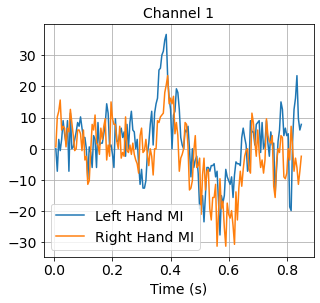

Sum of absolute squared difference w/o CSP: 16905.960000000003


In [18]:
##Plotting the data of each channel after applying CSP filters
## Each element in dataSplit list has each channel of data as a sublist, with its matching marker
## Plot the first 3 channels of the data for the first left hand MI Task
sf = 200; #200 Hz sampling frequency
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

timeSteps = np.linspace(1, 170, 170);
timeSteps = timeSteps / sf;
firstLeftHandMIIdx = np.where(markerTargetsOriginal==1)[0][0]
firstRightHandMIIdx = np.where(markerTargetsOriginal==2)[0][0]
exampleData = np.transpose(leftData[firstLeftHandMIIdx])
exampleData2 = np.transpose(rightData[firstRightHandMIIdx])
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for num in range(0,1):
    plt.subplot(5,5,num+1)
    plt.plot(timeSteps, exampleData[num,:])
    #plt.hold(True)
    plt.plot(timeSteps, exampleData2[num,:])
    plt.title("Channel {chNum}".format(chNum=num+1),fontdict = {'fontsize' : 14})
    plt.xlabel("Time (s)")
    plt.grid()
    plt.legend(['Left Hand MI', 'Right Hand MI'])
plt.show()
squaredAbsDiff = sum(((np.subtract(exampleData[1,:], exampleData2[2,:])))**2);
print("Sum of absolute squared difference w/o CSP: {}".format(squaredAbsDiff))

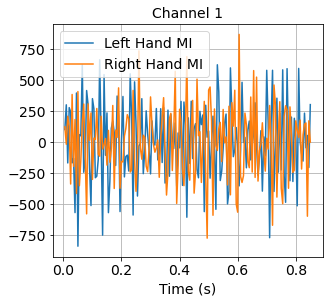

Sum of absolute squared difference with CSP: 31695466.30421385


In [20]:
##Plotting the data of each channel after applying CSP filters
## Each element in dataSplit list has each channel of data as a sublist, with its matching marker
## Plot the first 3 channels of the data for the first left hand MI Task
sf = 200; #200 Hz sampling frequency
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

timeSteps = np.linspace(1, 170, 170);
timeSteps = timeSteps / sf;
firstLeftHandMIIdx = np.where(markerTargetsOriginal==1)[0][0]
firstRightHandMIIdx = np.where(markerTargetsOriginal==2)[0][0]
exampleData = np.transpose(rightData_CSP[firstLeftHandMIIdx])
exampleData2 = np.transpose(rightData_CSP[firstRightHandMIIdx])
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for num in range(0,1):
    plt.subplot(5,5,num+1)
    plt.plot(timeSteps, exampleData[num,:])
    #plt.hold(True)
    plt.plot(timeSteps, exampleData2[num,:])
    plt.title("Channel {chNum}".format(chNum=num+1),fontdict = {'fontsize' : 14})
    plt.xlabel("Time (s)")
    plt.grid()
    plt.legend(['Left Hand MI', 'Right Hand MI'])
plt.show()
squaredAbsDiff = sum(np.subtract(exampleData[1,:], exampleData2[2,:])**2);
print("Sum of absolute squared difference with CSP: {}".format(squaredAbsDiff))

In [29]:
#Construct the target array and merge the data
leftTargets_CSP = np.tile(np.array([1,0]),(288,1))
rightTargets_CSP = np.tile(np.array([0,1]), (288,1))
markerTargets_CSP = np.vstack((leftTargets_CSP, rightTargets_CSP))
lrData_CSP = np.vstack((leftData_CSP, rightData_CSP))

#Sanity Check
print("lrData_CSP Shape: {arg1}\tmarkerTargets_CSP Shape: {arg2}".format(arg1=lrData_CSP.shape, arg2=markerTargets_CSP.shape))

lrData_CSP Shape: (576, 170, 21)	markerTargets_CSP Shape: (576, 2)


In [30]:
## Shuffle the data
lrData_CSP, markerTargets_CSP = shuffle(lrData_CSP, markerTargets_CSP, random_state=0)

NameError: name 'shuffle' is not defined

In [74]:
## Split into train and test sets
lrDataTrain_CSP, lrDataTest_CSP, markerTargetsTrain_CSP, markerTargetsTest_CSP = train_test_split(lrData_CSP, markerTargets_CSP, test_size=0.3, random_state=1)
markerTargetsTrain_CSP.shape

(403, 2)

In [75]:
## Reshape the data for time-series processing
## Syntax np.reshape((numExamples, numTimeSteps, numInputs/numFeatures))
lrDataTrainRe_CSP = lrDataTrain_CSP.reshape((lrDataTrain_CSP.shape[0], lrDataTrain_CSP.shape[1], lrDataTrain_CSP.shape[2]))
lrDataTestRe_CSP = lrDataTest_CSP.reshape((lrDataTest_CSP.shape[0], lrDataTest_CSP.shape[1], lrDataTest_CSP.shape[2]))


In [85]:
## Construct the model
LSTM_EEG_CSP = Sequential()
LSTM_EEG_CSP.add(LSTM((100),batch_input_shape=(None,lrDataTrainRe_CSP.shape[1], lrDataTrainRe_CSP.shape[2]), return_sequences=True))
LSTM_EEG_CSP.add(LSTM((50), return_sequences=False))
LSTM_EEG_CSP.add(Dense((2),activation='sigmoid'))

In [86]:
LSTM_EEG_CSP.summary()
sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
LSTM_EEG_CSP.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 170, 100)          48800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 79,102
Trainable params: 79,102
Non-trainable params: 0
_________________________________________________________________


In [87]:
history_CSP = LSTM_EEG_CSP.fit(lrDataTrain_CSP, markerTargetsTrain_CSP, epochs=100,verbose=2, batch_size=16)

Epoch 1/100
26/26 - 2s - loss: 0.6852 - accuracy: 0.5608
Epoch 2/100
26/26 - 2s - loss: 0.6160 - accuracy: 0.6998
Epoch 3/100
26/26 - 3s - loss: 0.5797 - accuracy: 0.7196
Epoch 4/100
26/26 - 2s - loss: 0.5358 - accuracy: 0.7618
Epoch 5/100
26/26 - 2s - loss: 0.5043 - accuracy: 0.7643
Epoch 6/100
26/26 - 2s - loss: 0.4884 - accuracy: 0.7866
Epoch 7/100
26/26 - 2s - loss: 0.4276 - accuracy: 0.8065
Epoch 8/100
26/26 - 2s - loss: 0.5327 - accuracy: 0.7643
Epoch 9/100
26/26 - 2s - loss: 0.4336 - accuracy: 0.8189
Epoch 10/100
26/26 - 2s - loss: 0.4207 - accuracy: 0.8139
Epoch 11/100
26/26 - 2s - loss: 0.3257 - accuracy: 0.8536
Epoch 12/100
26/26 - 3s - loss: 0.2656 - accuracy: 0.8983
Epoch 13/100
26/26 - 3s - loss: 0.2028 - accuracy: 0.9280
Epoch 14/100
26/26 - 2s - loss: 0.2432 - accuracy: 0.9057
Epoch 15/100
26/26 - 2s - loss: 0.2715 - accuracy: 0.8908
Epoch 16/100
26/26 - 2s - loss: 0.2587 - accuracy: 0.9156
Epoch 17/100
26/26 - 2s - loss: 0.2133 - accuracy: 0.9231
Epoch 18/100
26/26 - 2s

In [88]:
predictionsTest_CSP = LSTM_EEG_CSP.predict(lrDataTest_CSP)

In [89]:
predictionsTest_CSP[predictionsTest_CSP>0.5] = 1

In [90]:
predictionsTest_CSP[predictionsTest_CSP <= 0.5] = 0

In [91]:
comparisonArrayTest_CSP = predictionsTest_CSP == markerTargetsTest_CSP

In [92]:
correctCountTest = 0
for boolValues in comparisonArrayTest_CSP:
    if(boolValues[0] & boolValues[1]):
        correctCountTest += 1
falseCountTest = lrDataTest_CSP.shape[0] - correctCountTest

predictionsTrain = LSTM_EEG_CSP.predict(lrDataTrain_CSP)
predictionsTrain[predictionsTrain>0.5] = 1;
predictionsTrain[predictionsTrain<=0.5] = 0;
comparisonArrayTrain = predictionsTrain == markerTargetsTrain;

correctCountTrain = 0
for boolValues in comparisonArrayTrain:
    if(boolValues[0] & boolValues[1]):
        correctCountTrain += 1
falseCountTrain = lrDataTrain_CSP.shape[0] - correctCountTrain

In [93]:
print("#################################")
print("#################################")
print("### RESULTS AFTER APPLYING CSP ##")
print("#################################")
print("#################################")
print("#################################")
print("#################################")
print("Training Performance:\nCorrect MI Prediction: {}\nIncorrect MI Prediction: {}\nPercent Accuracy: {:.3f}%".format(correctCountTrain, falseCountTrain, (correctCountTrain*100/lrDataTrain.shape[0])))
print("#################################")
print("#################################")
print("Testing Performance:\nCorrect MI Prediction: {}\nIncorrect MI Prediction: {}\nPercent Accuracy: {:.3f}%".format(correctCountTest, falseCountTest, (correctCountTest*100/lrDataTest.shape[0])))
print("#################################")
print("#################################")

#################################
#################################
### RESULTS AFTER APPLYING CSP ##
#################################
#################################
#################################
#################################
Training Performance:
Correct MI Prediction: 403
Incorrect MI Prediction: 0
Percent Accuracy: 100.000%
#################################
#################################
Testing Performance:
Correct MI Prediction: 128
Incorrect MI Prediction: 45
Percent Accuracy: 73.988%
#################################
#################################
